In [129]:
import scipy as sp
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski
import tqdm
import find_skeleton
import scipy.stats


imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with secondary porosity

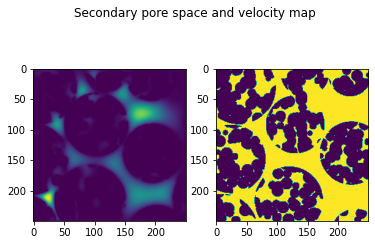

In [136]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png')


In [5]:
# testIM = primaryImage.astype(bool)
# testIM = testIM[:,:,slice]
# skelIM = ski.morphology.skeletonize(testIM)
#
# plt.imshow(skelIM)

# Extract pore network information

In [30]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]

secondaryRegions = snowFiltSecondary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1436
Peaks after trimming saddle points:  938
Peaks after trimming nearby peaks:  922
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 922/922 [00:10<00:00, 90.03it/s] 


In [31]:
ps.io.to_vtk(secondaryRegions,'snowRegionsSecondary')

# Plot velocity histogram from simulation

Text(0.5, 0, 'All pore velocities')

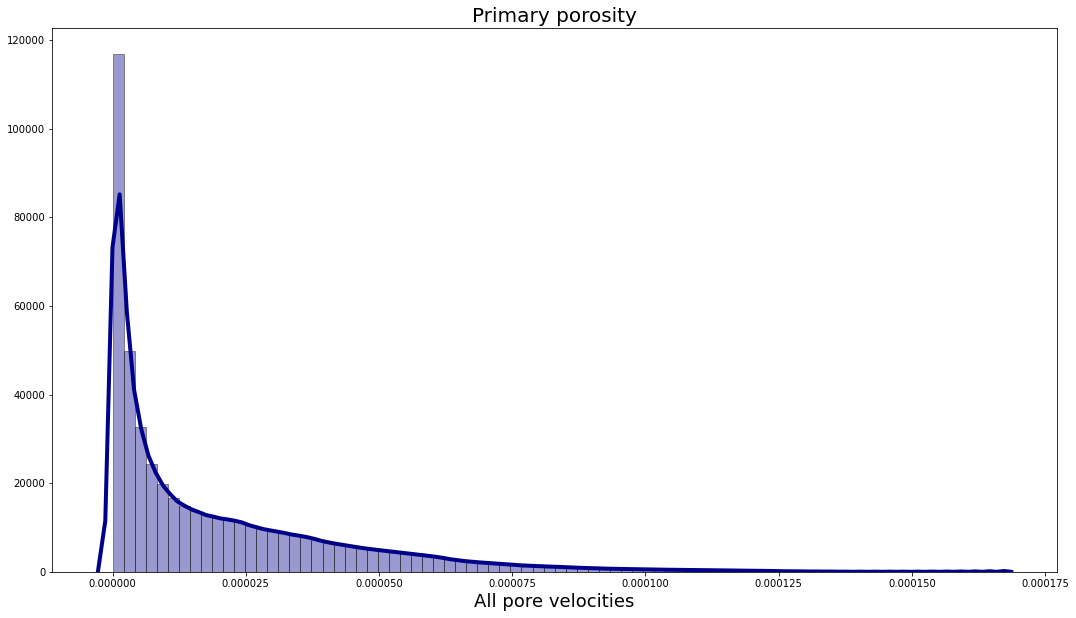

In [32]:
allSecondaryVelocities = np.ndarray.flatten(velDataNormSecondary)

filtIndex = allSecondaryVelocities > 0
trueZeroIndex = allSecondaryVelocities == 0

filtSecondaryVelocities = allSecondaryVelocities[filtIndex]
filtZeroSecondaryVelocities = allSecondaryVelocities[trueZeroIndex]

fig, axes = plt.subplots(1, 1, figsize=(18, 10))
sns.distplot(filtSecondaryVelocities, ax=axes, hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes.set_title('Primary porosity', fontsize=20)
axes.set_xlabel('All pore velocities', fontsize=18)


# Skeleton implementation


In [33]:
secondaryRegionData = ps.metrics.regionprops_3D(snowFiltSecondary.regions) #Gives properties for each region


100%|██████████| 922/922 [01:06<00:00, 13.90it/s]


------------------------------------------------------------
Calculating regionprops


Find skeleton for secondary image and collect info

In [34]:
len(np.unique(secondaryRegions))

923

In [35]:

cubeSize = len(secondaryImage)
secondarySkelImage = np.zeros(secondaryImage.shape)
edgeImage = np.zeros(secondaryImage.shape)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
regionStepImage = np.zeros(secondaryImage.shape)
skeletonDone = np.zeros(len(np.unique(secondaryRegions)))

poreDiamForMedian = []
for a in tqdm.tqdm(range(0, cubeSize), 'Main loop'):
    for b in range(cubeSize):
        for c in range(cubeSize):
            regionLabel = snowFiltSecondary.regions[a,b,c]
            if regionLabel != 0: # Don't want grains to be counted

                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    #index = snowFiltPrimary.regions[a,b,c]

                    # regionBorder = primaryRegionData[regionLabel].slice
                    # We don't want to use regionBorder or the slice feature! This gives a box outline
                    # not the actual pore!!!
                    # primarySkelImage[primaryRegions == regionLabel] = primaryRegionData[regionLabel].skeleton
                    #edgeImage[snowFiltPrimary.regions[a,b,c] == regionLabel] = regionData[regionLabel].border

                    # secondaryRegionImage[secondaryRegions == regionLabel] =  regionLabel

                    if skeletonDone[regionLabel] == 0:

                        regionStepImage[secondaryRegions == regionLabel] = 1
                        regionSkeleton = ski.morphology.skeletonize(regionStepImage)
                        # Save skeleton for this region
                        secondarySkelImage[secondaryRegions == regionLabel] = regionSkeleton[secondaryRegions == regionLabel]
                        print('skeleton done for ', regionLabel)

                        # Reset for next iteration
                        regionStepImage[secondaryImage == regionLabel] = 0
                        skeletonDone[regionLabel] = 1

                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = poreInfoSecondary['pore.diameter'][regionLabel-1]
                    poreDiamForMedian = np.append(poreDiamForMedian, poreInfoSecondary['pore.diameter'][regionLabel-1])
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam

Main loop: 100%|██████████| 250/250 [1:07:56<00:00, 16.31s/it]


skeleton done for  637
skeleton done for  907
skeleton done for  311
skeleton done for  838
skeleton done for  549
skeleton done for  561
skeleton done for  688
skeleton done for  456
skeleton done for  638
skeleton done for  115
skeleton done for  190
skeleton done for  554
skeleton done for  201
skeleton done for  489
skeleton done for  209
skeleton done for  465
skeleton done for  418
skeleton done for  855
skeleton done for  375
skeleton done for  55
skeleton done for  29
skeleton done for  837
skeleton done for  9
skeleton done for  350
skeleton done for  85
skeleton done for  30
skeleton done for  532
skeleton done for  286
skeleton done for  238
skeleton done for  149
skeleton done for  102
skeleton done for  310
skeleton done for  377
skeleton done for  86
skeleton done for  729
skeleton done for  784
skeleton done for  833
skeleton done for  711
skeleton done for  798
skeleton done for  170
skeleton done for  458
skeleton done for  809
skeleton done for  45
skeleton done for  

In [80]:
# Skeleton per pore region
cubeSize = len(secondaryImage)
skeletonImagePerPore = np.zeros(secondaryImage.shape)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1

                    tempImage[secondaryRegions == regionLabel] = 1
                    tempImage[secondaryRegions != regionLabel] = 0
                    skeletonImagePerPore = ski.morphology.skeletonize(tempImage)
                    secondarySkelImage[secondaryRegions == regionLabel] = skeletonImagePerPore[secondaryRegions == regionLabel]

                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = poreInfoSecondary['pore.diameter'][regionLabel-1]
                    poreDiamForMedian = np.append(poreDiamForMedian, poreInfoSecondary['pore.diameter'][regionLabel-1])
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam




Main loop:  61%|██████    | 560/923 [09:12<05:58,  1.01it/s]


KeyboardInterrupt: 

In [87]:
# Skeleton for all pores
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1

                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = poreInfoSecondary['pore.diameter'][regionLabel-1]
                    poreDiamForMedian = np.append(poreDiamForMedian, poreInfoSecondary['pore.diameter'][regionLabel-1])
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam




Main loop: 100%|██████████| 923/923 [00:15<00:00, 58.45it/s]


In [79]:
#secondarySkelImage[secondaryImage == 0] = 0
ps.io.to_vtk(secondarySkelImage,'secondarySkeletonWholeImage')

secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype(int)
secondaryImageOut[secondaryImage == 1] = 255
ps.io.to_vtk(secondaryImageOut,'secondaryImage')
secondaryImageOut[primaryImage == 255] = 1

In [19]:
testRegion = 167
oneRegionImage = np.zeros(secondaryImage.shape)
testRegionBorder = secondaryRegionData[testRegion].slice
oneRegionImage[secondaryRegions == testRegion] = 255

ps.io.to_vtk(oneRegionImage,'oneRegionImage')

# Skeletonize one pore region using python image library algorithm

In [29]:
testRegionNum = 44
oneRegionImage = np.zeros(secondaryImage.shape)
oneSkeletonImage = np.zeros(secondaryImage.shape)

testRegion = secondaryRegionData[testRegionNum]

oneRegionImage[secondaryRegions == testRegionNum] = 1
testSkel = ski.morphology.skeletonize(oneRegionImage)
oneSkeletonImage[testSkel > 0] = 200

oneRegionImage[oneRegionImage == 1] = 255
ps.io.to_vtk(oneRegionImage,'oneRegionImage')
ps.io.to_vtk(oneSkeletonImage,'oneSkeletonImage')

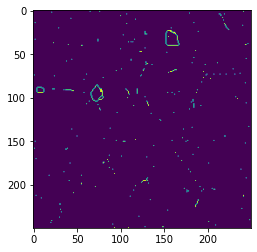

In [82]:
plt.imshow(secondarySkelImage[:,:,40])

# ps.io.to_vtk(primarySkelImage,'PS_skeletonImage')
#primaryImage[primaryImage == 1] = 255 # Make red/blue distinction
#ps.io.to_vtk(primaryImage,'primaryImage')


# Now plot velocitites on skeleton and extract information

In [95]:
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []
secondaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Main loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if secondarySkelImage[a,b,c] != 0:
                secondaryVelocitiesSkeleton = np.append(secondaryVelocitiesSkeleton,velDataNormSecondary[a,b,c])
                secondaryPoreDiamSkeleton = np.append(secondaryPoreDiamSkeleton, secondaryPoreDiamImage[a,b,c])
                secondaryPoreRegionSkeleton = np.append(secondaryPoreRegionSkeleton, secondaryRegions[a,b,c])

Main loop: 100%|██████████| 250/250 [00:43<00:00,  5.77it/s]


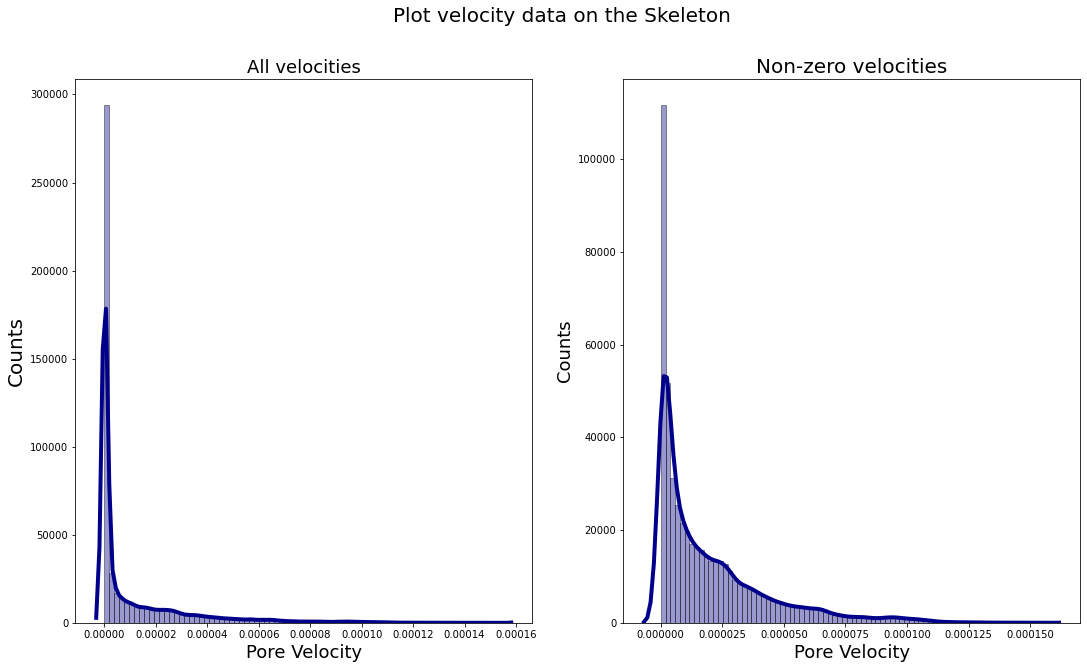

In [89]:
# The zeros seen here are truely no flow I think, they aren't pore walls and this is after the flow simulation, so
# even though the initial lattice state is v = 0, these are still zero

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Plot velocity data on the Skeleton', fontsize=20)

sns.distplot(secondaryVelocitiesSkeleton, ax=axes[0], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('All velocities', fontsize=18)
axes[0].set_xlabel('Pore Velocity', fontsize=18)
axes[0].set_ylabel('Counts', fontsize=20)

sns.distplot(secondaryVelocitiesSkeleton[secondaryVelocitiesSkeleton != 0], ax=axes[1], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Non-zero velocities', fontsize=20)
axes[1].set_xlabel('Pore Velocity', fontsize=18)
axes[1].set_ylabel('Counts', fontsize=18)

fig.savefig('poreVelHistograms.png')

# Plot pore velocities with pore diameters



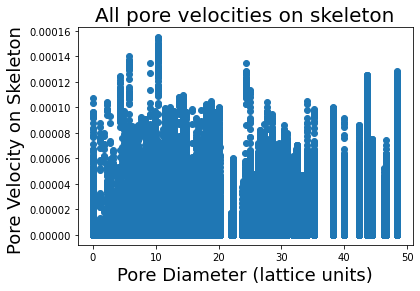

In [96]:
plt.scatter(secondaryPoreDiamSkeleton, secondaryVelocitiesSkeleton)
plt.xlabel('Pore Diameter (lattice units)', fontsize=18)
plt.ylabel('Pore Velocity on Skeleton ', fontsize=18)
plt.title('All pore velocities on skeleton', fontsize=20)

fig.savefig('allPoreVelocities.png')


Try taking median velocity

In [108]:
IQR_PoreVelocity =  []
meanPoreVelocity =  []
skeletonPoreDiam = []
skeletonPoreRegion = []
poreRegions, indices = np.unique(secondaryPoreRegionSkeleton, return_index='True')

for a in range(0, len(poreRegions)):
    currentRegion = poreRegions[a]
    poreRegionIndex = secondaryPoreRegionSkeleton[indices[a]]

    skeletonPoreVel = secondaryVelocitiesSkeleton[secondaryPoreRegionSkeleton == poreRegionIndex]

    meanPoreVelocity = np.append(meanPoreVelocity, np.mean(skeletonPoreVel) )
    IQR_PoreVelocity = np.append(IQR_PoreVelocity, scipy.stats.iqr(skeletonPoreVel, interpolation = 'midpoint'))
    skeletonPoreDiam = np.append(skeletonPoreDiam, poreDiamForMedian[int(poreRegionIndex)] )
    skeletonPoreRegion = np.append(skeletonPoreRegion, int(poreRegionIndex))

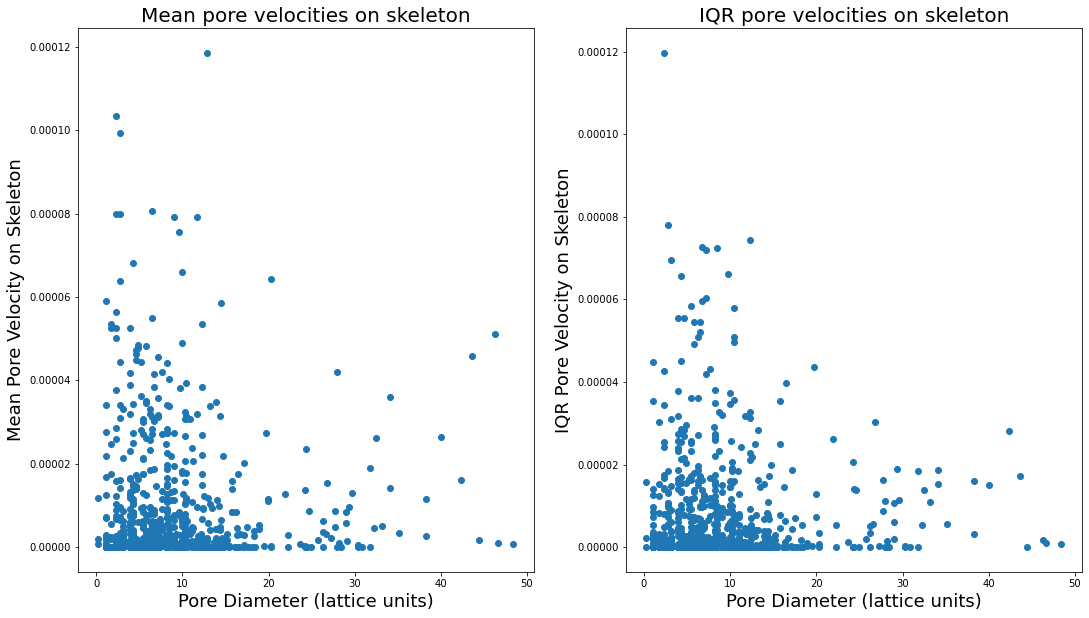

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].scatter(skeletonPoreDiam, meanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)

axes[1].scatter(skeletonPoreDiam, IQR_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('IQR Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('IQR pore velocities on skeleton', fontsize=20)

fig.savefig('poreVelAveraging.png')

Separate pores with low velocity


In [116]:
# Best choice for this? hardcoded to 0 per discussion on 4/2
noFlowVelCutoff = 0 # 0.5 * 10 ** float(-5)
print(noFlowVelCutoff)

0


In [146]:
poreRegions, indices = np.unique(secondaryPoreRegionSkeleton, return_index='True')
noFlowRegions = skeletonPoreRegion[IQR_PoreVelocity == 0]
noFlowImage = np.zeros(secondaryImage.shape)
flowImage = np.copy(secondaryImage)

for a in range(0, len(noFlowRegions)):
    regionInd = noFlowRegions[a]
    print('This is a no flow region:', regionInd)
    noFlowImage[secondaryRegions == regionInd] =  1
    flowImage[secondaryRegions == regionInd] = 0



This is a no flow region: 3.0
This is a no flow region: 6.0
This is a no flow region: 8.0
This is a no flow region: 11.0
This is a no flow region: 17.0
This is a no flow region: 27.0
This is a no flow region: 28.0
This is a no flow region: 37.0
This is a no flow region: 41.0
This is a no flow region: 46.0
This is a no flow region: 48.0
This is a no flow region: 52.0
This is a no flow region: 59.0
This is a no flow region: 60.0
This is a no flow region: 64.0
This is a no flow region: 70.0
This is a no flow region: 71.0
This is a no flow region: 74.0
This is a no flow region: 80.0
This is a no flow region: 82.0
This is a no flow region: 88.0
This is a no flow region: 99.0
This is a no flow region: 101.0
This is a no flow region: 106.0
This is a no flow region: 107.0
This is a no flow region: 108.0
This is a no flow region: 109.0
This is a no flow region: 112.0
This is a no flow region: 114.0
This is a no flow region: 116.0
This is a no flow region: 118.0
This is a no flow region: 120.0
T

In [140]:
# Rescale no Flow data
velImage = velDataNormSecondary
velImage = velImage / np.max(velImage)
velImage = velImage * 200
ps.io.to_vtk(velImage,'secondaryVelocityImage')

noFlowOut = noFlowImage
noFlowOut[noFlowImage == 1] = 255
ps.io.to_vtk(noFlowImage,'noFlowSecondaryRegionImage')

# Compute estimate of mobile porosity

Total Porosity

In [144]:
porosityCalc = ps.metrics.porosity(secondaryImage)
print('Total porosity:')
print(porosityCalc)

Total porosity:
0.545888832


Estimate of mobile porosity

In [147]:
# Get grains
flippedImage = np.copy(secondaryImage)
flippedImage[secondaryImage == 1] = 0
flippedImage[secondaryImage == 0] = 1
porosityCalc = ps.metrics.porosity(secondaryImage)

sumPorosity = np.sum(secondaryImage)/(np.sum(flippedImage)+np.sum(secondaryImage))
print(sumPorosity)

mobileOnes = np.sum(flowImage)
total = np.sum(flippedImage) + np.sum(flowImage) + np.sum(noFlowImage)
mobilePorosity = mobileOnes/total
print('Mobile porosity estimate:')
print(mobilePorosity)
print('Mobile fraction of porosity')
mobileFrac = (mobilePorosity/porosityCalc)
print(mobileFrac)

0.545888832
Mobile porosity estimate:
0.487801728
Mobile fraction of porosity
0.8935916974392324


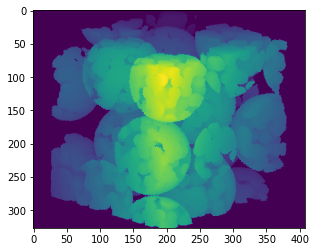

In [133]:
dispIM = np.copy(secondaryImage)
dispIM[secondaryImage == 1] = 255
#dispIM[secondaryImage == 1] = 0
totalPorosityImage = ps.visualization.show_3D(dispIM)
plt.imshow(totalPorosityImage)

plt.savefig('allPoreImage.png')

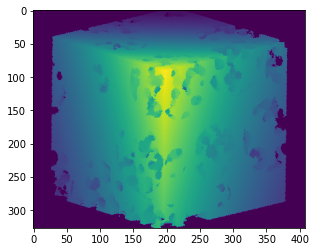

In [128]:
dispIM = np.copy(flowImage)
dispIM[flowImage == 0] = 255
dispIM[flowImage == 1] = 0
dispFlowImage = ps.visualization.show_3D(dispIM)
plt.imshow(dispFlowImage)

plt.savefig('flowImage.png')